In [ ]:
from imports import *
from exactDiagMethods import *
from globalMethods import  *
from vqteMethods import *


## H imag * iH real
## Compare matricies in seperate file
## Look at Joaquins python file for this 

ModuleNotFoundError: No module named 'tests'

In [ ]:
def main():
    # Initialize the simulation parameters
    N = 2
    gamma_L= 0.2
    gamma_R = 1.0
    eps = 1
    mu_L= 0.25
    mu_R= 1
    T_L = 10   
    T_R= 1
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 1
    
    #Layer = 2

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 6.0
    dt = 0.3
    nt = int(time/dt)

    

    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    #print("Exact Ham", exact_diag_ham)

    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R, J)

    
    
    # Generate initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)


    exact_diag_results, superoperator = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)
    
    print("This is the superoperator", superoperator)
    print("Ham real ", ham_real)
 

    #print("This is important", superoperator - (ham_imag.to_matrix()+ 1j*ham_real.to_matrix()))
    
 

    
    #print("Superoperator from exact diag method: ", superoperator)
    vqte_results, numoplist = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    
    #print("Difference", compare_superoperator_to_vqte(superoperator, ham_real, ham_imag) )
    
    #print("Number Operators: ", numoplist)
    # # Output results
    
    output_results(vqte_results, exact_diag_results, time, nt)

This is the superoperator [[-0.59625176+0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.5       +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.10374824+0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.59625176-1.j  0.        -2.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.10374824+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        -2.j -0.6       -1.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.5       +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.6       -2.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


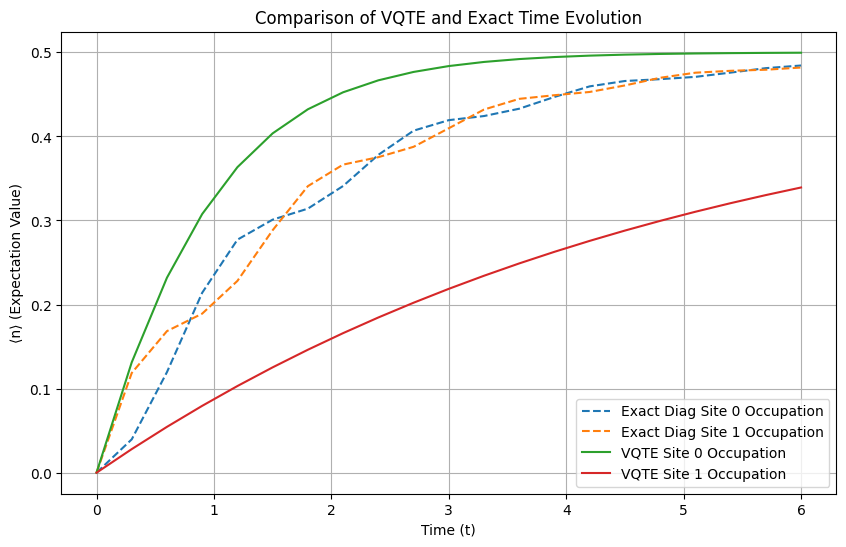

In [ ]:
main()